The goal of this notebook is to try and accumulate all of the previous information gathered regarding the instagram engagements with other information, and see if there is a way to accumulate it into one space in order to make this into a deliverable product. 

This means the joining of the actual instagram dataset, and then the extra research performed on the hashtags and @'s attached in each description.

# Step 0 : Import dependencies and visualization tools

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('coolwarm')
%matplotlib inline

# Step 1 : Load in Instagram Dataset, Derive Preliminary Features that require no outside data. 

In [2]:
def apply_profile_clusters_to_training(z,profiles):
    """Apply the clusters to the dataset, now in a form for prediction aligned with the other data. 
   
   """
    
    import re
    from numpy import zeros
    post_clusters = zeros(profiles.shape[1] - 1)
    tags_in_z =  list( dict.fromkeys(re.findall('@[a-z_0-9]*',z)) ) 
    
    if len(tags_in_z) == 0:
        return post_clusters
    for tag_in_z in tags_in_z:
        try:
            post_clusters = post_clusters + profiles[profiles['profile'] == tag_in_z].values[0][1:] 
        except: 
            pass
    return post_clusters


def cluster_profiles(instas,k):
    """
    """
    
    from sklearn.cluster import KMeans
    from sklearn import preprocessing
    from instagram_scraper import profile_df
    
    

    profiledf = profile_df.copy(deep=True)
    
    profiledf.dropna(inplace=True)
    profiledf['followers'] = profiledf['followers + post_count'].apply(lambda z: float(z.split(',')[0].replace('(','')))
    profiledf['post_count'] = profiledf['followers + post_count'].apply(lambda z: float(z.split(',')[1].replace(')','')))

    profiledf.drop('followers + post_count',axis=1,inplace=True)
    profiledf.drop('n_posts',axis=1,inplace=True)
    profiledf['followers'] = np.log10(profiledf['followers']+1)
    profiledf['post_count'] = np.log10(profiledf['post_count']+1)

    x = profiledf.drop('profile',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    kmeanModel = KMeans(n_clusters=k).fit(df)

    profiledf['Cluster'] = kmeanModel.labels_


    profiles = profiledf[['profile','Cluster']].copy()
    profiles = pd.get_dummies(profiles,columns=['Cluster'])

    instas['Clusters'] = instas['Description'].str.lower().apply(lambda z: apply_profile_clusters_to_training(z,profiles))

    clusters = pd.DataFrame(instas.Clusters.tolist(), columns=['profClus'+str(x) for x in np.arange(profiles.shape[1] - 1)])
    instas = instas.merge(clusters,left_index=True,right_index=True).drop('Clusters',axis=1)

    return instas

def apply_hashtag_clusters_to_training(z,hashtags):
    """Apply the clusters to the dataset, now in a form for prediction aligned with the other data. 
   
   """
    
    import re
    from numpy import zeros
    post_clusters = zeros(hashtags.shape[1] - 1)
    tags_in_z =  list( dict.fromkeys(re.findall('#[a-z_0-9]*',z)) ) 
    
    if len(tags_in_z) == 0:
        return post_clusters
    for tag_in_z in tags_in_z:
        #try:
        post_clusters = post_clusters + hashtags[hashtags['hashtags'] == tag_in_z].values[0][-(hashtags.shape[1] - 1):] 
       # except: 
       #     pass
    return post_clusters


def cluster_hashtags(instas,k):
    """Use k means clustering to partition hashtags in the descriptions into groups. 
    
    """

    from instagram_scraper import hashtag_df

    

    
    hashtagdf = hashtag_df.copy(deep=True)
    hashtagdf.drop('n_posts',axis=1,inplace=True)
    hashtagdf['# of posts'] = np.log10(hashtagdf['# of posts']+1)

    from sklearn.cluster import KMeans
    from sklearn import preprocessing

    x = hashtagdf.drop('hashtags',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)

    kmeanModel = KMeans(n_clusters=k).fit(df)
    hashtagdf['Cluster'] = kmeanModel.labels_

    hashtags = hashtagdf[['hashtags','Cluster']].copy()
    hashtags = pd.get_dummies(hashtags,columns=['Cluster'])


    instas['Clusters'] = instas['Description'].str.lower().apply(lambda z: apply_hashtag_clusters_to_training(z,hashtags))
    clusters = pd.DataFrame(instas.Clusters.tolist(), columns=['hashClus'+str(x) for x in np.arange(hashtags.shape[1] - 1)])
    instas = instas.merge(clusters,left_index=True,right_index=True).drop('Clusters',axis=1)
    return instas

In [3]:
#utilitiy functions before data processing. 
def find_dunks(z):
    dunk_words = ['slam','jam','dunk','putback','rim','windmill','flush','oop']
    for dw in dunk_words:
        if dw in z.lower(): 
            return 1
    return 0

def find_buzzer_beaters(z):
    buzzer_beater_words = ['buzz','beat','clock','winner']
    for bbw in buzzer_beater_words:
        if bbw in z.lower():
            return 1
    return 0


def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def process_data(file,training=False):
    """Loads in file, either the training or holdout set, and transforms it into the dataframe we want using the variable 
    changes based solely on that particular dataframe, as well as based on exogenous features such as profiles tagged, and hashtags used. 
    
    Parameters
    ----------
    
    file : csv 
        Csv file of the instagram posts. 
        
    training : bool
        Whether or not the inputfile is the training set. If true, this will also have attached a y output, in addition to X. 
        
    
    Returns
    --------
    
    X : dataframe
        ML ready dataframe of the associated features used to capture engagmeent rates. 
        
        Further documentation of each feature provided below. 
        
    y : optional return Dataframe
        For training purposes only, the output values of engagment to train ML model(s) on. 
        
    """
    
    import pandas as pd
    
    instas = pd.read_csv(file,encoding = 'unicode_escape')
    instas.fillna('',inplace=True)
    
    instas['Description_Len'] = instas['Description'].apply(len)
    instas['num@s'] = instas['Description'].apply(lambda z: z.count('@'))
    instas['num#s'] = instas['Description'].apply(lambda z: z.count('#'))
    instas['num?s'] = instas['Description'].apply(lambda z: z.count('?')) # a shitty proxy for emojis
    import re
    instas['numCAPs'] = instas['Description'].apply(lambda z: len(re.findall(r'[A-Z]',z)))

    instas['Buzzer Beater?'] = instas['Description'].apply(lambda z: find_buzzer_beaters(z)) #shitty proxy for buzzer beaters
    instas['Dunk?'] = instas['Description'].apply(lambda z:  find_dunks(z)) #shitty proxy for buzzer beaters


    import datetime

    instas['Timezone'] = instas['Created'].str.split(' ',expand =True)[2]
    instas['Date'] = instas['Created'].str.split(' ',expand = True)[0]
    instas['Month'] = instas['Date'].str.split('-',expand = True)[1]

    instas['Time'] = instas['Created'].str.split(' ',expand = True)[1]
    instas['Hour'] = instas['Time'].str.split(':',expand=True)[0]

    instas['Date'] = pd.to_datetime(instas['Date']).astype(datetime.datetime)

    instas['Weekday'] = instas['Date'].apply(lambda z: str(z.weekday()))
    instas['Year'] = instas['Created'].apply(lambda z: z.split('-')[0])
    
    
    instas = cluster_profiles(instas,k=11)#make k unique clusters of profiles, and apply that to dataset. 
    instas = cluster_hashtags(instas,k=8)#make k unique clusters of profiles, and apply that to dataset. 

    instas['Followers Gained Since Last Post'] = -instas['Followers at Posting'].diff(1).shift(-1).fillna(0)
    if training:
        X = instas.drop(columns=['Engagements','Description','Created','Followers at Posting','Date','Time']).copy()
        y = instas['Engagements']
    else:   
        X = instas.drop(columns=['Engagements','Description','Created','Followers at Posting','Date','Time']).copy()
        
    X = pd.get_dummies(X)
    if training:
        return X,y
    #otherwise, 
    return X
    

In [4]:
X, y = process_data('Business Analytics/training_set.csv',training=True)

Already created profile_df, loading now.
Already created hashtag_df, loading now.
Scraping complete. Now have dataframes containing information regarding the tagged accounts and hashtags used in each instagram post of the training set. Make sure to generalize for holdout too!


In [5]:
for col in X.columns:
    print(col)

Description_Len
num@s
num#s
num?s
numCAPs
Buzzer Beater?
Dunk?
profClus0
profClus1
profClus2
profClus3
profClus4
profClus5
profClus6
profClus7
profClus8
profClus9
profClus10
hashClus0
hashClus1
hashClus2
hashClus3
hashClus4
hashClus5
hashClus6
hashClus7
Followers Gained Since Last Post
Type_Album
Type_Photo
Type_Video
Timezone_EDT
Timezone_EST
Month_01
Month_02
Month_03
Month_04
Month_05
Month_06
Month_07
Month_08
Month_09
Month_10
Month_11
Month_12
Hour_00
Hour_01
Hour_02
Hour_03
Hour_04
Hour_05
Hour_06
Hour_07
Hour_08
Hour_09
Hour_10
Hour_11
Hour_12
Hour_13
Hour_14
Hour_15
Hour_16
Hour_17
Hour_18
Hour_19
Hour_20
Hour_21
Hour_22
Hour_23
Weekday_0
Weekday_1
Weekday_2
Weekday_3
Weekday_4
Weekday_5
Weekday_6
Year_2017
Year_2018
Year_2019


In [6]:
X_holdout = process_data('Business Analytics/holdout_set.csv',training=False)

# Step 2 Load In Exogeneous Features Such as Hashtag Popularity and Profile Clout

In [7]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6)

model = xgb.XGBRegressor(n_estimators=555,booster='dart')#choice(models)

print("Model used: ", model)
model.fit(X_train,y_train)
print("Training score: ", model.score(X_train,y_train))
print("Original Score", model.score(X_test,y_test))

def mean_absolute_percentage_error(y_true, y_pred):
    import numpy as np
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = y_test
y_pred = model.predict(X_test)

#y_pred = np.array([round(y) for y in y_pred])

print("MAPE Test Score ", mean_absolute_percentage_error(y_true, y_pred))


Model used:  XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=555,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Training score:  0.9628658958360513
Original Score 0.9345056043170389
MAPE Test Score  5.4386262394768385


In [8]:
X.columns

Index(['Description_Len', 'num@s', 'num#s', 'num?s', 'numCAPs',
       'Buzzer Beater?', 'Dunk?', 'profClus0', 'profClus1', 'profClus2',
       'profClus3', 'profClus4', 'profClus5', 'profClus6', 'profClus7',
       'profClus8', 'profClus9', 'profClus10', 'hashClus0', 'hashClus1',
       'hashClus2', 'hashClus3', 'hashClus4', 'hashClus5', 'hashClus6',
       'hashClus7', 'Followers Gained Since Last Post', 'Type_Album',
       'Type_Photo', 'Type_Video', 'Timezone_EDT', 'Timezone_EST', 'Month_01',
       'Month_02', 'Month_03', 'Month_04', 'Month_05', 'Month_06', 'Month_07',
       'Month_08', 'Month_09', 'Month_10', 'Month_11', 'Month_12', 'Hour_00',
       'Hour_01', 'Hour_02', 'Hour_03', 'Hour_04', 'Hour_05', 'Hour_06',
       'Hour_07', 'Hour_08', 'Hour_09', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Weekday_0',
       'Weekday_1', 'Weekday_2', 'Weekday_3', 

## what regression points are having the most trouble?
plt.title("Frequency of Offsets btw True and Predicted")
plt.hist(y_true.values - y_pred,bins=100)
plt.xlabel("y_true - y_pred (# of engagements)")
plt.ylabel("Frequency")
plt.figure(figsize=(10,10))
plt.plot(y_true.values,100*abs(y_true.values - y_pred)/ y_true.values,'b.')
plt.title("Absolute % Error vs. True Engagements")
plt.xlabel('True # of Engagements')
plt.ylabel('Absolute % Error')

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(-1, 78)

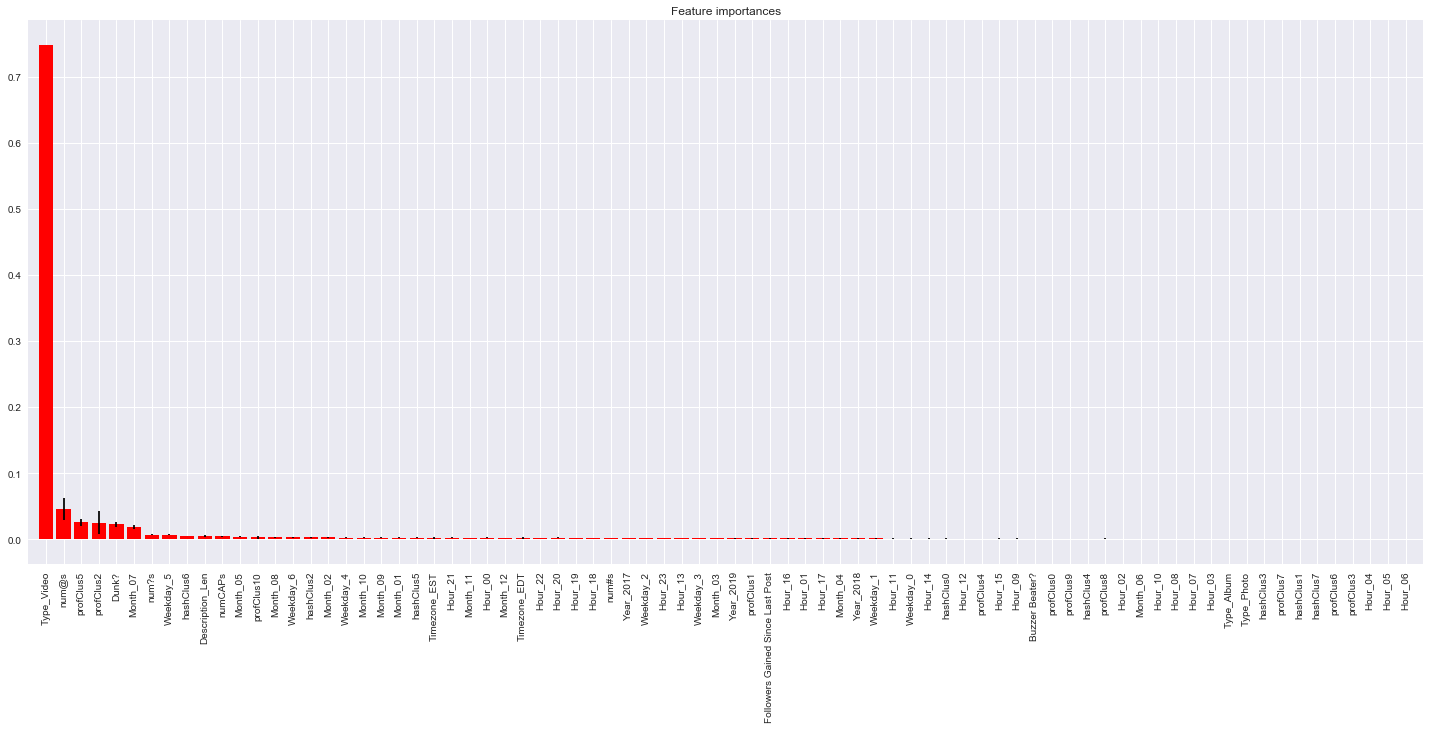

In [9]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor

# Build a classification task using 3 informative features

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)
 
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")
col_names = []
for f in range(X.shape[1]):
 #   print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
 #   print(X.columns[indices[f]])
    col_names.append(X.columns[indices[f]])

# Plot the feature importances of the forest
plt.figure(figsize=(25,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), col_names,rotation=90)
plt.xlim([-1, X.shape[1]])


In [10]:
from sklearn.model_selection import cross_val_score


In [11]:
scores = cross_val_score(model, X, y, cv=5)

In [12]:
print(np.mean(scores) , "+/- " , 2*np.std(scores) ) 

0.9202499678546875 +/-  0.04328741719696989


In [13]:
X_holdout = process_data('Business Analytics/holdout_set.csv')

So unfortunatelyit appears that this model does pretty terribly for "low engagement" posts. I want to make sure the holdout set isn't consisting of posts similar to those low engagment ones, otherwise this model is focusing on the wrong stuff. 

The idea here is to compare the holdout to the training set, and see how similar the data is in the current space, once transformed into a 2d tsne space. 


Step 1: Cluster into high and low engagement posts, corresponding to the error attributed. 

Next, transform all data into tsne, labels  = holdout set, training set - high error, training set - low error, and compare to see how bad this may end up . 

In [14]:
y_true = y_test.values
y_pred = model.predict(X_test)

In [15]:
mean_absolute_percentage_error(y_pred=y_pred,y_true=y_true)

5.4386262394768385

In [17]:
X_test['APE'] = 100*abs(y_true - y_pred)/ y_true

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


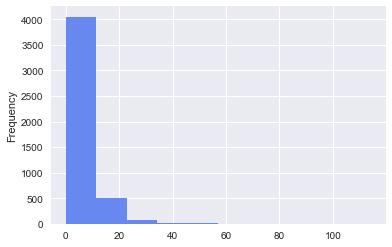

In [18]:
X_test['APE'].plot(kind='hist')

In [19]:
X_test['Good Job?'] = X_test['APE'].apply(lambda z: 1 if z < 10 else 0)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
X_holdout['Holdout?'] = 2*np.ones(len(X_holdout))

In [21]:
from sklearn.manifold import TSNE

In [22]:
X_tsne = pd.concat([X_test.drop(columns=['APE','Good Job?']),X_holdout.drop('Holdout?',axis=1)],axis=0)

In [23]:
X_embedded = TSNE(n_components=2).fit_transform(X_tsne)

In [24]:
labels = pd.concat([X_test['Good Job?'],X_holdout['Holdout?']])

In [25]:
badfits = X_embedded[labels.values== 0] # bad fit on training data

goodfits = X_embedded[labels== 1] # good fit on training data


holdouts = X_embedded[labels== 2] # was a part of the holdout set

In [26]:
X_embedded_df = pd.DataFrame(X_embedded)

In [27]:
X_embedded_df['labels'] = labels.values

In [28]:
X_embedded_df

,0,1,labels
0,10.906606,51.394863,1.0
1,39.944633,34.415642,1.0
2,-28.720184,-86.279465,1.0
3,35.361355,27.117920,1.0
4,5.377502,25.477314,1.0
5,12.418283,49.152977,1.0
6,-64.128815,1.435689,1.0
7,10.674987,-1.784750,0.0
8,33.268963,21.534502,1.0
9,-47.499840,-9.306292,0.0


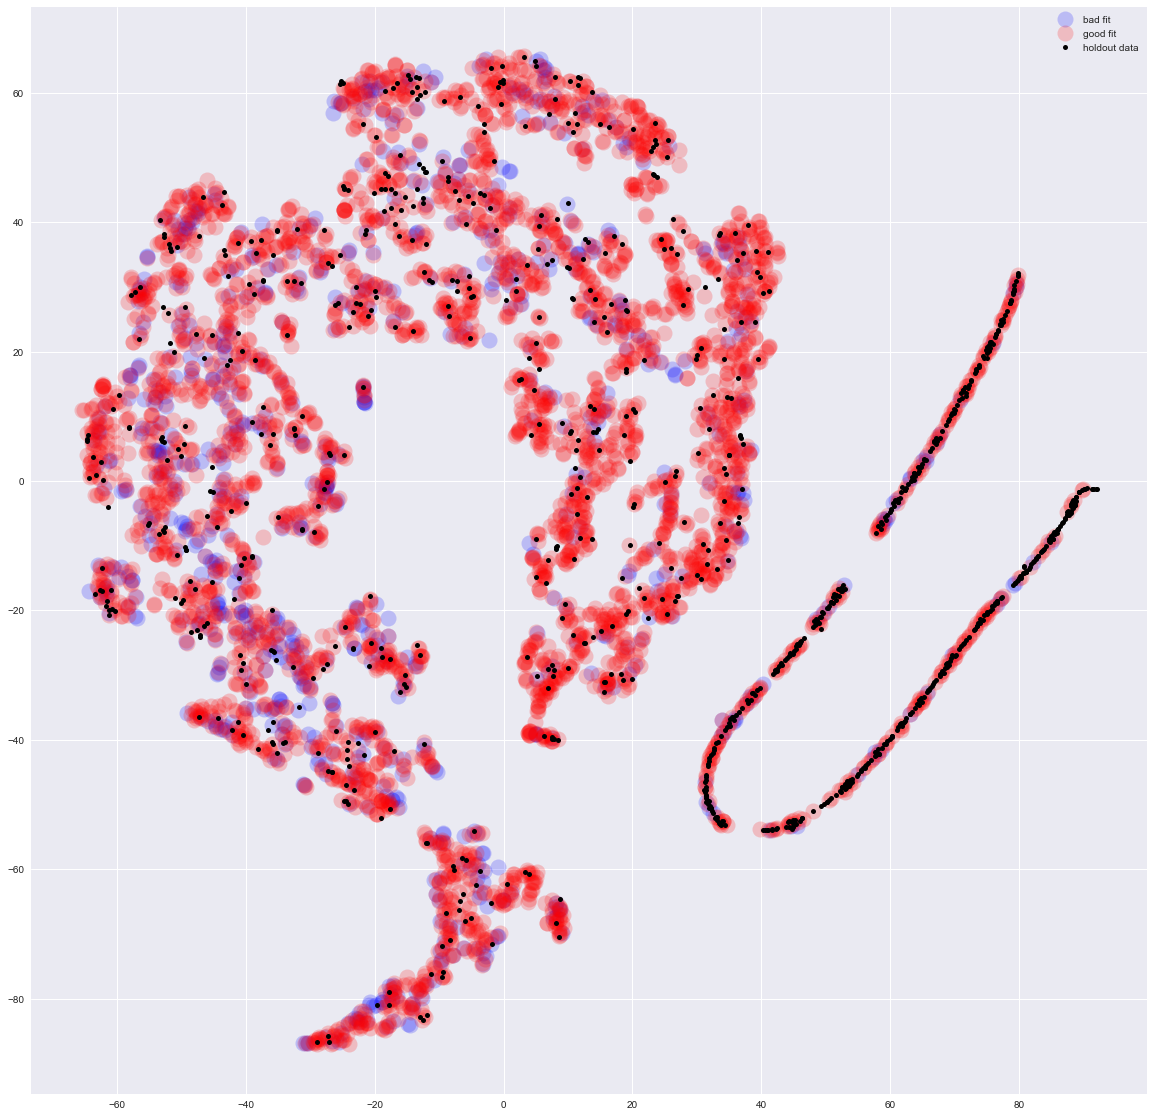

In [29]:

plt.figure(figsize=(20,20))
plt.plot(X_embedded_df.loc[X_embedded_df.labels == 0][0],
         X_embedded_df.loc[X_embedded_df.labels == 0][1],'bo',label = 'bad fit',alpha=.2,markersize=16)
plt.plot(X_embedded_df.loc[X_embedded_df.labels == 1][0],
         X_embedded_df.loc[X_embedded_df.labels == 1][1],'ro',label = 'good fit',alpha=.2,markersize=16)


plt.plot(X_embedded_df.loc[X_embedded_df.labels == 2][0],
         X_embedded_df.loc[X_embedded_df.labels == 2][1],'ko',label = 'holdout data',alpha=1,markersize=5)
plt.legend()


Next is to actually find all this red data close to the holdout data, and emphasize modelling on those datapoints.

Make the test set as similar to the holdout set, and minimize that. 

In [39]:
X_embedded_df.loc[(X_embedded_df[0] < -20) & (X_embedded_df[1] > -20)]

,0,1,labels
5,-70.823433,15.339811,1.0
12,-37.270073,40.800041,1.0
23,-22.833439,47.371777,1.0
35,-22.060608,-8.078472,1.0
37,-45.734840,37.458710,1.0
53,-29.348595,31.874502,1.0
69,-43.119553,36.682289,1.0
70,-29.943548,43.134384,1.0
80,-44.693687,36.746044,1.0
83,-66.430359,9.717224,1.0


In [43]:
X_tsne.sample(n=3)

,Description_Len,num@s,num#s,num?s,numCAPs,Buzzer Beater?,Dunk?,profClus0,profClus1,profClus2,...,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Year_2017,Year_2018,Year_2019
6794,41,0,0,0,0,1,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
6914,25,1,0,0,1,0,0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,1,0,0
596,105,3,1,11,9,0,0,0.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,1


In [42]:
X_tsne[X_tsne.index== 4029]

,Description_Len,num@s,num#s,num?s,numCAPs,Buzzer Beater?,Dunk?,profClus0,profClus1,profClus2,...,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Year_2017,Year_2018,Year_2019


In [111]:
X_holdout.sample(n=3)

,Description_Len,num@s,num#s,num?s,numCAPs,Buzzer Beater?,Dunk?,profClus0,profClus1,profClus2,...,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Year_2017,Year_2018,Year_2019,Holdout?
678,128,2,2,0,26,1,0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,1,0,2.0
834,67,0,0,0,3,0,0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,2.0
529,61,2,1,0,4,0,0,1.0,0.0,1.0,...,0,0,0,0,0,1,0,1,0,2.0


In [70]:
plt.plot(badfits[:,0],badfits[:,1],'.')

IndexError: too many indices for array

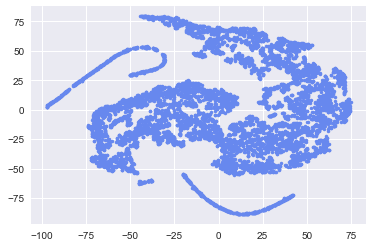

In [67]:
plt.plot(X_embedded[:,0],X_embedded[:,1],'.')